**NBA Salaries Analysis - Aarish Irfan**

**PREDICTING NBA SALARIES USING MACHINE LEARNING**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#NBA players stats 1950-2017
nba = pd.read_csv('NBA.csv')

**DATA CLEANING**

We will first drop unknown columns and rows with NaN values, and then remove rows wiht seasons before 2005.

In [3]:
nba = nba.drop(['blanl', 'blank2'], axis=1)
nba = nba.drop(nba.tail(2).index)
nba = nba.dropna()

In [4]:
#only considering stats after 2005 and renaming columns
nbaRecent = nba.loc[(nba['Season Start'] >= 2005) & (nba[' Player Salary in $ '].notna())]
nbaRecent.rename(columns={"Pos": "Position","Tm": "Team","G":"Games Played","GS":"Games Started",
                          " Player Salary in $ ":"Salary","Season Start":"Season", "MP":"Minutes Played"}, inplace=True)
nbaRecent.shape[0]
nbaRecent.head()

,#,Season,Player Name,Salary,Position,Age,Team,Games Played,Games Started,Minutes Played,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
24,24304.0,2017.0,A.J. Hammons,"$1,312,611.00",C,24.0,DAL,22.0,0.0,163.0,...,45.0%,8.0,28.0,36.0,4.0,1.0,13.0,10.0,21.0,48.0
25,20357.0,2010.0,A.J. Price,"$762,195.00",PG,23.0,IND,56.0,2.0,865.0,...,80.0%,12.0,76.0,88.0,106.0,35.0,3.0,59.0,53.0,410.0
26,20966.0,2011.0,A.J. Price,"$854,389.00",PG,24.0,IND,50.0,0.0,795.0,...,66.7%,16.0,56.0,72.0,111.0,29.0,1.0,53.0,61.0,323.0
27,21529.0,2012.0,A.J. Price,"$885,120.00",PG,25.0,IND,44.0,1.0,568.0,...,80.0%,13.0,48.0,61.0,86.0,20.0,2.0,32.0,30.0,172.0
29,22709.0,2014.0,A.J. Price,"$62,552.00",SG,27.0,MIN,28.0,0.0,99.0,...,0.0%,1.0,9.0,10.0,13.0,1.0,0.0,7.0,5.0,44.0


We will also remove the dollar sign in the salary column and convert percentages to decimals

In [5]:
nbaRecent['Salary'] = nbaRecent['Salary'].str.replace(',','')
nbaRecent['Salary'] = nbaRecent['Salary'].str.replace('$','')
nbaRecent['Salary'] = nbaRecent['Salary'].astype(float)
for column in nbaRecent.columns:
    c = str(column)
    if (c[-1] == '%'):
        if (nbaRecent[c].dtype == object):
            nbaRecent[c] = nbaRecent[c].str.replace('%','')
            nbaRecent[c] = nbaRecent[c].astype(float)
            nbaRecent[c] = nbaRecent[c] / 100.0   


Since players who have played less than a certain amount of games may distort the data later on when doing analysis per game, we will first check the fraction of players who have played less than a certain number of games. We will then only keep those players who have played more than that number.

In [6]:
#checking how many players played less than a certain games in a season
gamesPlayed = []
percentOfPlayers = []
lowerBound = int(nbaRecent['Games Played'].min())
upperBound = int(nbaRecent['Games Played'].max())
step = int((upperBound - lowerBound) / 14)
for i in range(lowerBound, upperBound, step):
    gamesPlayed.append(i)
    percentOfPlayers.append(nbaRecent[nbaRecent['Games Played'] <= i].shape[0] / nbaRecent.shape[0])
PP = pd.Series(percentOfPlayers, index = gamesPlayed)
PP

1     0.000825
6     0.017323
11    0.045783
16    0.068261
21    0.101052
26    0.153021
31    0.198804
36    0.235306
41    0.277583
46    0.317591
51    0.366880
56    0.428748
61    0.487317
66    0.572489
71    0.654980
76    0.772737
81    0.937307
dtype: float64

Text(0, 0.5, 'Fraction of number of players')

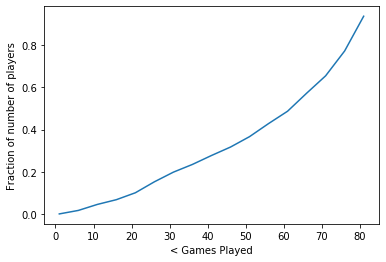

In [7]:
plt.plot(gamesPlayed, percentOfPlayers)
plt.xlabel("< Games Played")
plt.ylabel("Fraction of number of players")

Around 4.57% of the players played less than 11 games in a season. We will hence only keep players who have played more than 11 games.

In [8]:
nbaRecent = nbaRecent[nbaRecent['Games Played'] > 11]
nbaRecent.shape[0]

4627

**EXPLORATORY DATA ANALYSIS AND VISUALIZATION**

Let us first see how the salaries are distributed

Text(0.5, 0, 'Salary in USD millions')

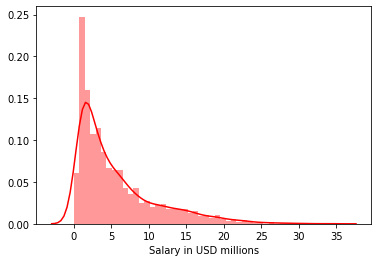

In [9]:

sns.distplot(nbaRecent['Salary'] / 1000000, color = 'red').set_xlabel('Salary in USD millions')

Text(0.5, 0, 'Salary in USD millions')

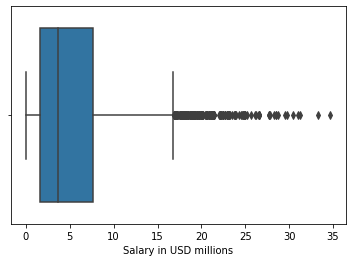

In [10]:
sns.boxplot(x=(nbaRecent['Salary'] / 1000000)).set_xlabel('Salary in USD millions')

A lot of salaries are between 2 to 8 million but a few players earn have very high salaries, skewing the data to the left. 

We will now examine salary per position, salary per team and salary per age

Text(0.5, 0, 'Salary in USD millions')

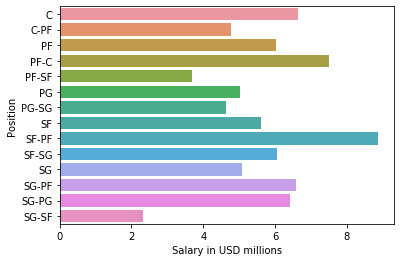

In [11]:
nbaPosition = nbaRecent.copy()
nbaPosition['Salary'] = nbaPosition['Salary'] / 1000000
nbaPosition = nbaPosition[['Salary','Position']].groupby('Position').mean().reset_index()
sns.barplot(x='Salary', y='Position', data = nbaPosition).set_xlabel('Salary in USD millions')


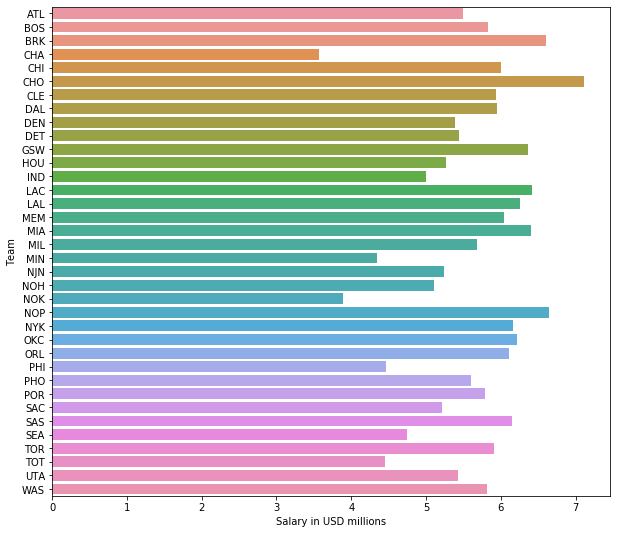

In [12]:
nbaTeam = nbaRecent[['Salary','Team']].groupby('Team').mean().reset_index()
nbaTeam['Salary'] = nbaTeam['Salary'] / 1000000
plt.figure(figsize=(10,9))
teamplot = sns.barplot(x='Salary', y='Team', data = nbaTeam).set_xlabel('Salary in USD millions')

Text(0, 0.5, 'Salary in USD millions')

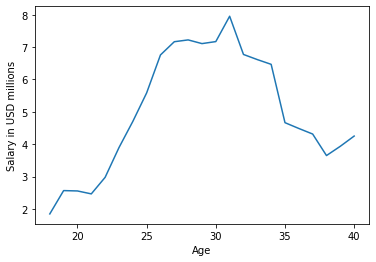

In [13]:
nbaAge = nbaRecent[['Age','Salary']].groupby('Age').mean().reset_index()
nbaAge['Salary'] = nbaAge['Salary'] / 1000000
sns.lineplot(x="Age", y="Salary", data=nbaAge).set_ylabel('Salary in USD millions')


As you can observe, the small/power forward, the Hornets' and age 31 have the highest average salary in each category. Again, there isn't a noticeable pattern in salaries that would make any of the these three features a strong predictor in salary

We will now examine a scatterplot of salary and points per season to salary to analyse their relationship

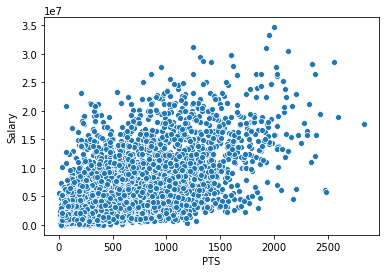

In [14]:
nbaPoints = nbaRecent[['PTS','Salary']]
sns.scatterplot(x='PTS',y='Salary',data=nbaPoints)

A meaningful pattern can not be deduced

Since analyzing individual relationships between salary and other variables does not lead to fruitful conclusions, we need to examine all of them together. Let us now examine a 'heat map' of the variables based on their Pearson r^2 values.

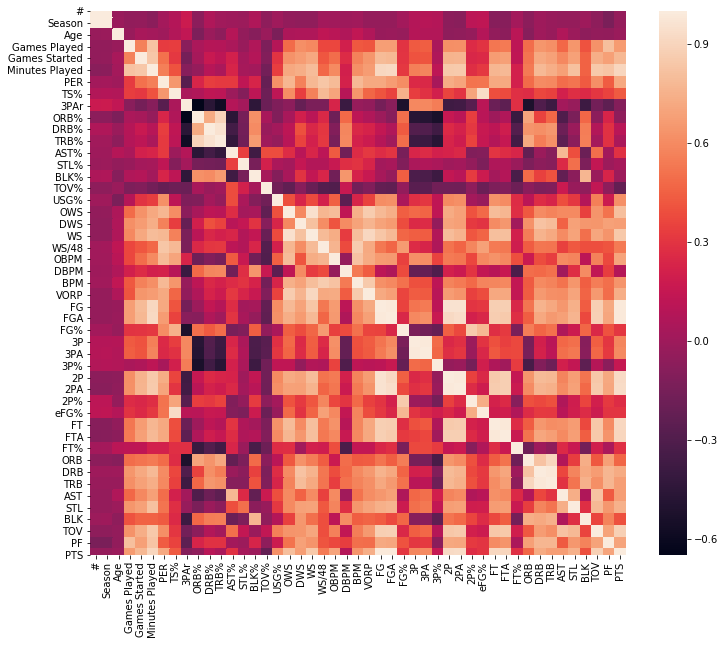

In [15]:
heatmap = nbaRecent.drop('Salary', axis = 1)
fig, a = plt.subplots(figsize=(12,10))
correlation = heatmap.corr()
sns.heatmap(correlation, xticklabels=correlation.columns.values, yticklabels=correlation.columns.values, ax=a)

**FEATURE ENGINEERING**

From the salary distrbutions above, we can see that a lot of salaries are in the range of 1 - 15 million. We will now check the fraction of players who have earned less than a certain amount of salary.

In [16]:
gamesPlayed = []
percentOfPlayers = []
lowerBound = int(nbaRecent['Salary'].min())
upperBound = int(nbaRecent['Salary'].max())
step = int((upperBound - lowerBound) / 14)
for i in range(lowerBound, upperBound, step):
    gamesPlayed.append(i)
    percentOfPlayers.append(nbaRecent[nbaRecent['Salary'] <= i].shape[0] / nbaRecent.shape[0])
PP = pd.Series(percentOfPlayers, index = gamesPlayed)
PP

8819        0.000216
2485514     0.374325
4962209     0.595634
7438904     0.739356
9915599     0.818673
12392294    0.877891
14868989    0.920035
17345684    0.953750
19822379    0.975362
22299074    0.986600
24775769    0.993732
27252464    0.996974
29729159    0.998919
32205854    0.999568
34682549    0.999784
dtype: float64

Text(0, 0.5, 'Fraction of number of players')

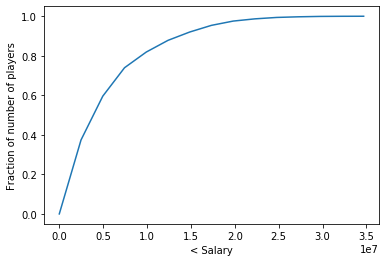

In [17]:
plt.plot(gamesPlayed, percentOfPlayers)
plt.xlabel("< Salary")
plt.ylabel("Fraction of number of players")

As you can see, around 95% of the players earn less than 17 million. Yet the highest five percent of players had a salary range from 17 to 34 million. These outliers would heavily bias our model so we are removing them from our data.

In [18]:
nbaRecentRaw = nbaRecent.copy()
nbaRecent = nbaRecentRaw[nbaRecentRaw['Salary'] <= 17000000]
nbaRecent.shape[0]

4398

Since there would be a disparity in the number of matches played by each player due to injuries, metrics like Points and Turnovers would also follow a similar pattern. To eliminate this bias, we will calculate these metrics per match.

In [19]:
nbaRecent.columns

Index(['#', 'Season', 'Player Name', 'Salary', 'Position', 'Age', 'Team',
       'Games Played', 'Games Started', 'Minutes Played', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

Since position may be an important predictor of salary, we will convert each position into a numerical value. 

In [20]:
nbaRecent['PositionEncoded'] = nbaRecent['Position'].astype('category').cat.codes
nbaRecent['PositionEncoded'].head()

24     0
25     5
26     5
27     5
29    10
Name: PositionEncoded, dtype: int8

In [21]:
perGameStats = ['FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
nbaPerGame = nbaRecent.drop(columns=perGameStats, axis=1)
for c in perGameStats:
    nbaPerGame[c + '/G'] = nbaRecent[c] / nbaRecent['Games Played']
nbaPerGame.head()

,#,Season,Player Name,Salary,Position,Age,Team,Games Played,Games Started,Minutes Played,...,FTA/G,ORB/G,DRB/G,TRB/G,AST/G,STL/G,BLK/G,TOV/G,PF/G,PTS/G
24,24304.0,2017.0,A.J. Hammons,1312611.0,C,24.0,DAL,22.0,0.0,163.0,...,0.909091,0.363636,1.272727,1.636364,0.181818,0.045455,0.590909,0.454545,0.954545,2.181818
25,20357.0,2010.0,A.J. Price,762195.0,PG,23.0,IND,56.0,2.0,865.0,...,1.339286,0.214286,1.357143,1.571429,1.892857,0.625000,0.053571,1.053571,0.946429,7.321429
26,20966.0,2011.0,A.J. Price,854389.0,PG,24.0,IND,50.0,0.0,795.0,...,1.620000,0.320000,1.120000,1.440000,2.220000,0.580000,0.020000,1.060000,1.220000,6.460000
27,21529.0,2012.0,A.J. Price,885120.0,PG,25.0,IND,44.0,1.0,568.0,...,0.795455,0.295455,1.090909,1.386364,1.954545,0.454545,0.045455,0.727273,0.681818,3.909091
29,22709.0,2014.0,A.J. Price,62552.0,SG,27.0,MIN,28.0,0.0,99.0,...,0.071429,0.035714,0.321429,0.357143,0.464286,0.035714,0.000000,0.250000,0.178571,1.571429


Due to wage inflation over time, salaries have been somewhat increasing over the years, as shown in the graph below

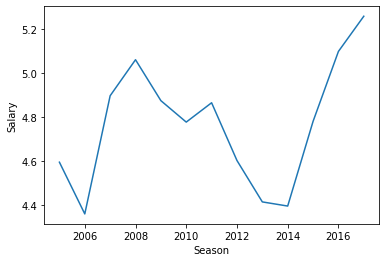

In [22]:
nbaSeason = nbaRecent[['Season','Salary']].groupby('Season').mean().reset_index()
nbaSeason['Salary'] = nbaSeason['Salary'] / 1000000
sns.lineplot(x='Season',y='Salary',data=nbaSeason)

To convert our salaries to a standard scale, we can use salary cap data, which is a good predictor of where NBA salaries are heading. We have converted salary cap data from the internet into a csv and will merge it with our data

In [23]:
salaryCap = pd.read_csv('SalaryCap.csv')
salaryCap.head()


,Season,SalaryCap
0,2005,43870000
1,2006,49500000
2,2007,53135000
3,2008,55630000
4,2009,58680000


We will now find a multiplicative factor as follows: 
(2017 year salary cap) / (current year salary cap)
We will multiply this factor with our salaries to account for inflation

In [24]:
salaryCap['Season'] = salaryCap['Season'].astype(float)
salaryCap['SalaryCap'] = salaryCap['SalaryCap'].astype(float)
nbaInflatedSalaries = pd.merge(nbaPerGame, salaryCap, on="Season", how="left")
nbaInflatedSalaries['InflatedSalary'] = ((94143000 / nbaInflatedSalaries['SalaryCap']) 
                                         * nbaInflatedSalaries['Salary']).astype(int)
nbaInflatedSalaries[['Salary','InflatedSalary']].head()

,Salary,InflatedSalary
0,1312611.0,1312611
1,762195.0,1243593
2,854389.0,1385754
3,885120.0,1435598
4,62552.0,100356


In order to predict the salary through our machine learning models, we need to pick the most correlated variables with salary as a high number of variables could increase the model complexity and lead to higher bias.

In [25]:
corrmat = nbaInflatedSalaries.corr(method='pearson', min_periods=1)
r_square = corrmat ** 2
cols = r_square.nlargest(14, 'InflatedSalary')['InflatedSalary'].index
colsSeries = pd.Series(cols)
colsSeries

0     InflatedSalary
1             Salary
2              PTS/G
3               FG/G
4              FGA/G
5               2P/G
6              2PA/G
7              FTA/G
8               FT/G
9                 WS
10             TOV/G
11             DRB/G
12              VORP
13               OWS
dtype: object

These are the top 13 features that contribute the most to predicting salary. However, there is a high amount of mulit-collinearity between some of the features so we will drop them.

First, we will drop salary since that it is derived from InflatedSalary, which is the variable we are trying to predict.

In [26]:
colsSeriesOne = colsSeries.drop(labels=[1])
colsSeriesOne

0     InflatedSalary
2              PTS/G
3               FG/G
4              FGA/G
5               2P/G
6              2PA/G
7              FTA/G
8               FT/G
9                 WS
10             TOV/G
11             DRB/G
12              VORP
13               OWS
dtype: object

Now, we will drop all the variables with a high level of multi-collinearity. The following variables are highly correlated : 

FG/G and FGA/G

2P/G and 2PA/G

FT/G and FTA/G

PTS/G and FG/G + 2P/G

So, we will drop FGA/G, 2PA/G FTA/G, FG/G, 2P/G from colsSeriesOne

In [27]:
colsSeriesTwo = colsSeriesOne.drop(labels=[4, 6, 7, 3, 5]).reset_index().drop('index',axis=1)
columnsToUse = colsSeriesTwo.values.flatten()

In [28]:
rank = np.arange(8)
mostcorrelated = pd.DataFrame(columnsToUse, rank)
mostcorrelated.columns = ['Most Correlated']
mostcorrelated = mostcorrelated.iloc[1:]
mostcorrelated


,Most Correlated
1,PTS/G
2,FT/G
3,WS
4,TOV/G
5,DRB/G
6,VORP
7,OWS


These are the seven most correlated features with salary. Here's a brief description of them:-

PTS/G : Points per Game

FTPG : free throws made per game

WS : Share of wins a player contributes to his team

VORP : Value over replacement player is a box score estimate that a player contributed above a replacement level player

TOV/G : Turnover percentage calculates the percentage of a team’s turnovers that a player has while on the floor

DRB/G : Defensive rebounds per game

OWS : Offensive wins shares is the share of wins a player contributes to his team from offense

We will now visualize these features through a feature matrix and a correlation heatmap to show correlation.

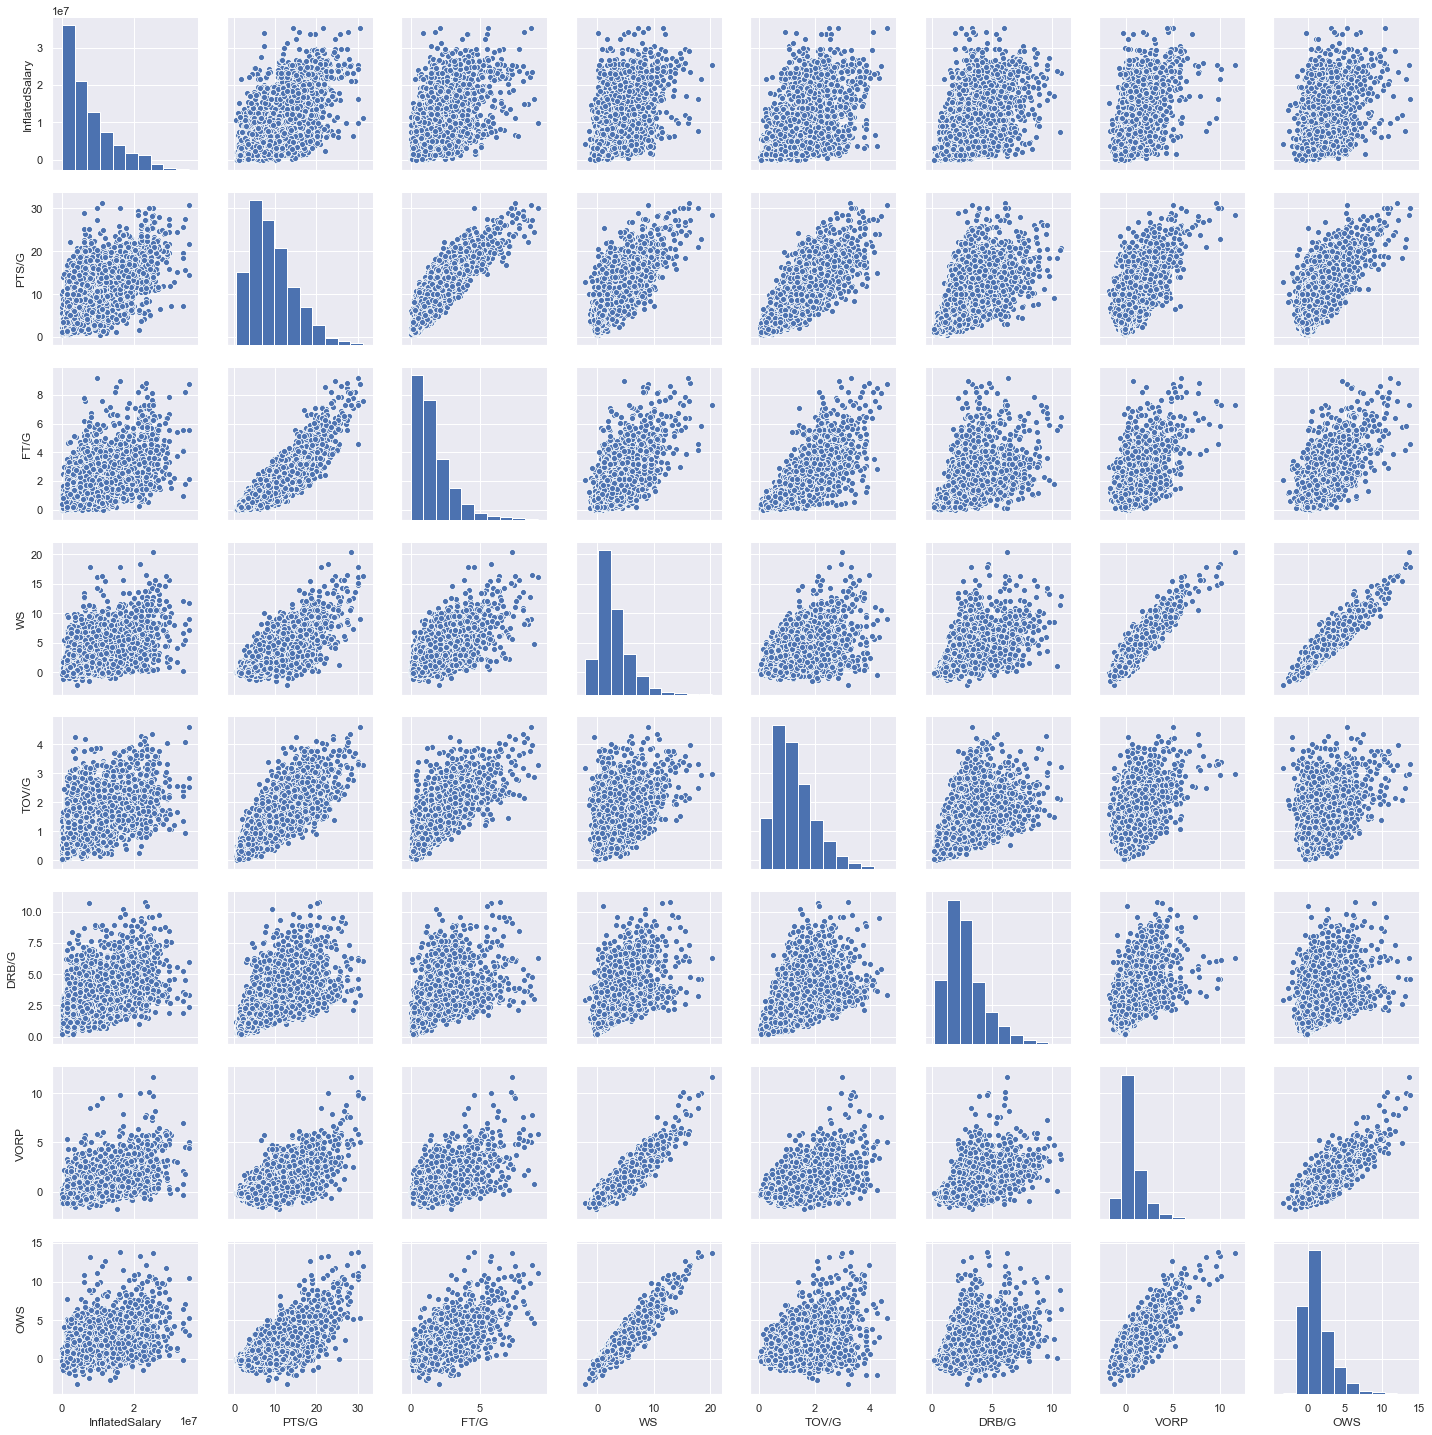

In [29]:
sns.set()
sns.pairplot(nbaInflatedSalaries[columnsToUse], height=2.5)
plt.show()

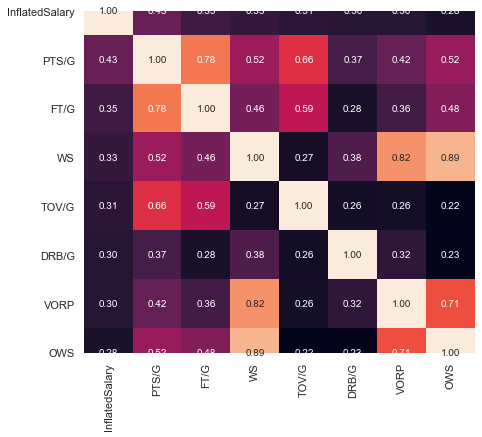

In [30]:
corHeatMap = nbaInflatedSalaries[columnsToUse].corr()
corHeatMap_square = corHeatMap ** 2
f, ax = plt.subplots(figsize=(7, 7))
sns.set(font_scale=1.25)
hm = sns.heatmap(corHeatMap_square, cbar=False, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=columnsToUse, xticklabels=columnsToUse)
plt.show()

So now the final dataset we will use for machine learning will include these seven features as well as the InflatedSalary that we are trying to predict

In [31]:
ml_dataset = nbaInflatedSalaries[columnsToUse]
ml_dataset.shape[0]
ml_dataset.head()

,InflatedSalary,PTS/G,FT/G,WS,TOV/G,DRB/G,VORP,OWS
0,1312611,2.181818,0.409091,0.0,0.454545,1.272727,-0.1,-0.2
1,1243593,7.321429,1.071429,1.2,1.053571,1.357143,0.0,0.4
2,1385754,6.460000,1.080000,0.3,1.060000,1.120000,-0.3,-0.4
3,1435598,3.909091,0.636364,0.7,0.727273,1.090909,0.0,0.2
4,100356,1.571429,0.000000,0.0,0.250000,0.321429,-0.1,-0.1


**MACHINE LEARNING**

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

We will first normalize the data to ensure our models produce a better result. Then, we will split our data into 75% training and 25% test to evaluate our models

In [33]:
X = ml_dataset.drop(['InflatedSalary'], axis = 1)
Y = ml_dataset['InflatedSalary']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state = 0)

We will first train a **Linear Regression** model.

In [34]:
Lin_Reg = LinearRegression().fit(X_train, Y_train)
Y_train_pred = Lin_Reg.predict(X_train)
Y_test_pred = Lin_Reg.predict(X_test)
rmseLinReg = np.sqrt(mean_squared_error(Y_test_pred, Y_test))
rmseLinReg

4719347.18996997

Now we will train a **Ridge Regression** model

In [35]:
Ridge_Reg = linear_model.Ridge(alpha=.5).fit(X_train, Y_train)
Y_train_pred = Ridge_Reg.predict(X_train)
Y_test_pred = Ridge_Reg.predict(X_test)
rmseRidgeReg = np.sqrt(mean_squared_error(Y_test_pred, Y_test))
rmseRidgeReg

4719318.043805333

Since both the regression models have a similar error, we will now train a **neural network**.

In [36]:
nn = MLPRegressor(hidden_layer_sizes=(12,8,6), activation='relu', solver='adam', max_iter=2500, random_state=40)
nn.fit(X_train,Y_train)
y_train_pred = nn.predict(X_train)
y_test_pred = nn.predict(X_test)
rmseNN = np.sqrt(mean_squared_error(y_test_pred, Y_test))
rmseNN

4717144.758949222

The Neural Network performs slightly better than the regression models. Now a **decision tree** will be trained

In [37]:
dtr = DecisionTreeRegressor( criterion='mse', max_depth=3, max_features=None, max_leaf_nodes=15,
                          min_impurity_decrease=0.4, min_impurity_split=None, min_samples_leaf = 2, 
                           min_samples_split = 3, min_weight_fraction_leaf = 0.0, presort = False,
                           splitter ='best')
dtr.fit(X_train,Y_train)
y_train_pred = dtr.predict(X_train)
y_test_pred = dtr.predict(X_test)
rmseDTR = np.sqrt(mean_squared_error(y_test_pred, Y_test))
rmseDTR

4935835.142122868

The decision tree is worse than all the models so far. Multiple decision trees, known as a **random forest model** might perform better so we will now train it.

In [38]:
rf = RandomForestRegressor(n_estimators=20, max_depth = 4, random_state = 40)
rf.fit(X_train,Y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmseRF = np.sqrt(mean_squared_error(y_test_pred, Y_test))
rmseRF



4690328.440317281

The random forest performs the best among all the models so far. Next up is a **Support Vector Machine** model

In [39]:
sv = svm.SVR()
sv.fit(X_train,Y_train)
y_train_pred = sv.predict(X_train)
y_test_pred = sv.predict(X_test)
rmseSV = np.sqrt(mean_squared_error(y_test_pred, Y_test))
rmseSV

7081797.579452902

The Support Vector Machine has a very high error!

After trying all these models, we can analyze them in a bar chart as a fraction of the standard deviation of the salaries.

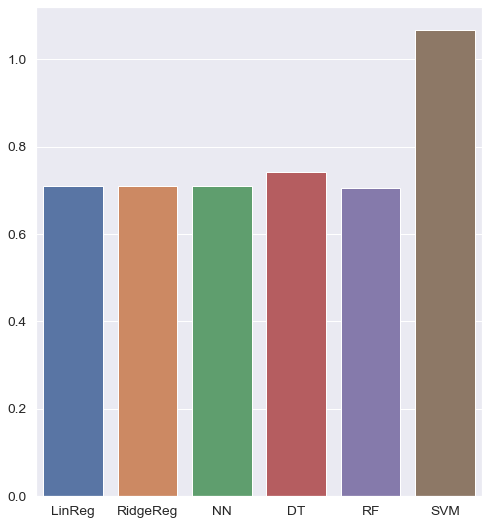

In [40]:
sd = ml_dataset['InflatedSalary'].std()
rmses = [rmseLinReg/sd, rmseRidgeReg/sd, rmseNN/sd, rmseDTR/sd, rmseRF/sd, rmseSV/sd]
categories = ['LinReg','RidgeReg','NN','DT','RF','SVM']
plt.figure(figsize=(8,9))
sns.barplot(x=categories,y=rmses)

The best model is our **random forest**, which accurately predicts salaries within 0.7 standard deviations of the original values

Now we will use this model to predict salaries of the NBA players and distinguish between the overvalued and undervalued players

In [41]:
#performing same operations on dataset with outliers
perGameStats = ['FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS']
nbaPerGameRaw = nbaRecentRaw.drop(columns=perGameStats, axis=1)
for c in perGameStats:
    nbaPerGameRaw[c + '/G'] = nbaRecentRaw[c] / nbaRecentRaw['Games Played']
nbaInflatedSalariesRaw = pd.merge(nbaPerGameRaw, salaryCap, on="Season", how="left")


nbaInflatedSalariesRaw['InflatedSalary'] = ((94143000 / nbaInflatedSalariesRaw['SalaryCap']) 
                                         * nbaInflatedSalariesRaw['Salary']).astype(int)
X_to_predict_one = nbaInflatedSalariesRaw[columnsToUse]


In [42]:
predicted_dataset = X_to_predict_one.copy()
X_to_predict_two = X_to_predict_one.drop(columns = ['InflatedSalary'], axis = 1)
predicted_dataset['PredictedSalary'] = rf.predict(X_to_predict_two)
predicted_dataset.head()

,InflatedSalary,PTS/G,FT/G,WS,TOV/G,DRB/G,VORP,OWS,PredictedSalary
0,1312611,2.181818,0.409091,0.0,0.454545,1.272727,-0.1,-0.2,1.473904e+07
1,1243593,7.321429,1.071429,1.2,1.053571,1.357143,0.0,0.4,1.836518e+07
2,1385754,6.460000,1.080000,0.3,1.060000,1.120000,-0.3,-0.4,1.770532e+07
3,1435598,3.909091,0.636364,0.7,0.727273,1.090909,0.0,0.2,1.728078e+07
4,100356,1.571429,0.000000,0.0,0.250000,0.321429,-0.1,-0.1,1.245842e+07


A player is undervalued if their actual salary is less than their predicted salary from the model. We will now separate the undervalued and overvalued players to discover insights regarding their age.

In [43]:

dataset_to_analyze = nbaRecentRaw[['Player Name','Age','Position','Team']].reset_index().drop('index',axis=1)
dataset_to_analyze['InflatedSalary'] = predicted_dataset['InflatedSalary']
dataset_to_analyze['PredictedSalary'] = predicted_dataset['PredictedSalary']
dataset_to_analyze.head()

,Player Name,Age,Position,Team,InflatedSalary,PredictedSalary
0,A.J. Hammons,24.0,C,DAL,1312611,1.473904e+07
1,A.J. Price,23.0,PG,IND,1243593,1.836518e+07
2,A.J. Price,24.0,PG,IND,1385754,1.770532e+07
3,A.J. Price,25.0,PG,IND,1435598,1.728078e+07
4,A.J. Price,27.0,SG,MIN,100356,1.245842e+07


Mean Age of undervalued players:  24.73
Mean Age of overvalued players:  30.21


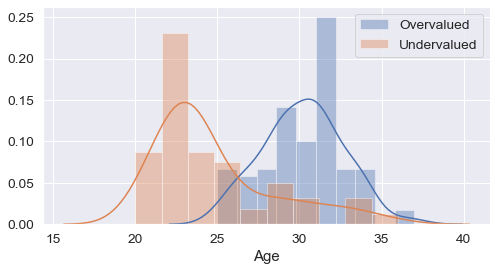

In [44]:
dataset_to_analyze['SalaryDifference'] = dataset_to_analyze['InflatedSalary'] - dataset_to_analyze['PredictedSalary']
overvalued = dataset_to_analyze[dataset_to_analyze['SalaryDifference'] > 0].nlargest(100, 'SalaryDifference')
undervalued = dataset_to_analyze[dataset_to_analyze['SalaryDifference'] < 0].nsmallest(100, 'SalaryDifference')
plt.figure(figsize=(8,4))
sns.distplot(overvalued['Age'], label='Overvalued')
sns.distplot(undervalued['Age'], label='Undervalued')
plt.legend()
print("Mean Age of undervalued players: ", undervalued['Age'].mean())
print("Mean Age of overvalued players: ", overvalued['Age'].mean())

Observing the distribution of ages for the top 100 undervalued and overvalued players, there is a key discovery: 

**Younger players are being undervalued in the NBA. Their performance statistics predict that they are worth much higher salaries**

**Older players are being overvalued in the NBA. Their performance statistics predict that they are worth much lower salaries**